
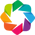

In [1]:
import matplotlib
import poloniex
import datetime
import holoviews as hv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')

In [2]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=720)
ether = poloniex.get_ohlc('USDT_ETH',start, end)
btc = poloniex.get_ohlc('USDT_BTC', start,end)

In [3]:
ether.head()

close      high       low      open  quoteVolume  \
date                                                                       
2016-02-02 17:30:00  2.357682  2.357682  2.357682  2.357682      0.00000   
2016-02-02 17:35:00  2.357682  2.357682  2.357682  2.357682      0.00000   
2016-02-02 17:40:00  2.357682  2.357682  2.357682  2.357682      0.00000   
2016-02-02 17:45:00  2.150000  2.184128  2.150000  2.184128      8.31748   
2016-02-02 17:50:00  2.150000  2.150000  2.150000  2.150000      0.00000   

                        volume  weightedAverage  
date                                             
2016-02-02 17:30:00   0.000000         2.357682  
2016-02-02 17:35:00   0.000000         2.357682  
2016-02-02 17:40:00   0.000000         2.357682  
2016-02-02 17:45:00  17.904712         2.152661  
2016-02-02 17:50:00   0.000000         2.150000

In [4]:
btc.tail()

close          high           low          open  \
date                                                                          
2018-01-22 17:05:00  10640.157336  10693.071564  10559.892371  10559.892371   
2018-01-22 17:10:00  10600.000000  10640.157336  10585.001686  10619.001004   
2018-01-22 17:15:00  10589.001686  10617.000000  10589.001686  10617.000000   
2018-01-22 17:20:00  10564.999999  10589.001686  10525.570539  10589.001686   
2018-01-22 17:25:00  10565.904941  10576.570538  10532.570539  10543.021122   

                     quoteVolume        volume  weightedAverage  
date                                                             
2018-01-22 17:05:00   111.715219  1.190301e+06     10654.776345  
2018-01-22 17:10:00     6.736344  7.144810e+04     10606.361476  
2018-01-22 17:15:00    15.883312  1.682434e+05     10592.465192  
2018-01-22 17:20:00     7.985218  8.444571e+04     10575.253687  
2018-01-22 17:25:00     7.689624  8.119799e+04     10559.422542

In [5]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    #df.reset_index(level=0, inplace=True)
    df['date'] = df.index
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))

stock_symbols = ['ETH', 'BTC',]
data = {"ETH": ether, 'BTC':btc}
dmap = hv.DynamicMap(load_symbol, kdims='Symbol').redim.values(Symbol=stock_symbols)

In [11]:
%%opts Curve [width=700] {+framewise}
dmap

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [9]:
%%opts Scatter [width=700] (color='black')
smoothed = dmap*rolling(dmap, rolling_window=30)*rolling_outlier_std(dmap)
smoothed

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Rolling correlation

Let's look at rolling correlations but only for the last 1000 prices.

In [10]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_corr(w, **kwargs):
    S = ether['close'].rolling(w).corr(other=btc['close'])
    ether['corrBTC'] = S
    

    return hv.Curve(ether.iloc[-1000:], ('date', 'Date'), ('corrBTC','Rolling correlation'))
    
winsize = {s:rolling_corr(s) for s in range(10,60,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (corrBTC)

## Volatility

Volatility is finance jargon for variance in the price series. It is a proxy to risk since the more the price varies the easier it is to loose money on a bad trade. 

In [12]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_vol(w, symbol):
    dt = data[symbol]
    S = dt['close'].rolling(w).std()
    dt['Volatility'] = S
    dt['date'] = ether.index

    return hv.Curve(dt.iloc[-1000:], ('date', 'Date'), ('Volatility','Rolling volatility'))

stock_symbols = ['ETH', 'BTC',]
data = {"ETH": ether, 'BTC':btc}    
winsize = range(10,60,2)
rvol = hv.DynamicMap(rolling_vol, kdims=['Wsize', 'Symbol']).redim.values(Symbol=stock_symbols).redim.range(Wsize=(10,60))
rvol

:DynamicMap   [Wsize,Symbol]

## Calculating rates of return
Rates of return are a way to understand how much money you make when you buy some coin and hold it for a period of time. 
Here we will show how to calculate these rates directly from the pandas dataframe on different time frames. It is defined as the price of coin the day you sold it minus the price you bought it for, divided price of purchase.
$$\frac{P_s-P_b}{P_b}=\frac{P_s}{P_b}-1$$
Let's do this for both our coin time series assuming 5-minute time window, i.e. the 5-minute return rate of this coins recently. 

In [10]:
ether['5m_return'] = ether.close/ether.close.shift(1) - 1
btc['5m_return'] = btc.close/btc.close.shift(1) - 1

In [11]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
hv.Curve(ether[-10000:], ('date', 'Date'),('5m_return', '5m Return rate'), label='Ether returns').hist(num_bins=150)

:AdjointLayout
   :Curve   [date]   (5m_return)
   :Histogram   _return]   (5m_return_frequency)

As we can see in the figure above, the return rates are centered around 0, meaning thar if you bought and sold randomly this last year, you are likely have had an average return of 0.

Would it be different if we had invested in BTC instead? To check we can make a scatter plot from the returns of these two coins.

In [12]:
%%opts Scatter [width=700, height=500, show_grid=True] {+framewise}
%%opts Curve (color='red' line_width=1.5)
c = hv.Curve((np.arange(-.1,.1,.01),np.arange(-.1,.1,.01)),'ETH', 'BTC')
s = hv.Scatter((ether['5m_return'][-10000:],btc['5m_return'][-10000:]),kdims=['ETH'], vdims=['BTC']).redim.range(ETH=(-.1,.1),BTC=(-.1,.1)).hist(num_bins=150, dimension=['ETH','BTC'])
c*s

:AdjointLayout
   :Overlay
      .Curve.I   :Curve   [ETH]   (BTC)
      .Scatter.I :Scatter   [ETH]   (BTC)
   :Histogram   [BTC]   (BTC_frequency)
   :Histogram   [ETH]   (ETH_frequency)

From the figure above we can see that things where not much better for BTC either. The red line means equal returns. But it may make more sense to simply look at the average return over the entire period in percentage:

In [13]:
ether['5m_return'].mean() *100

0.08634518231486855

In [14]:
btc['5m_return'].mean() *100

0.0021754401822601894

It seems that ETH has some advantage. But he accumulated rate of return (assuming no reinvesting) is more informative:

In [15]:
ether['5m_return'].mean()*len(ether['5m_return']) *100

17904.450659628827

In [16]:
btc['5m_return'].mean()*len(btc['5m_return']) *100

451.09710075329065

The average returns calculated over the entire period above don't give us much information. Like with the rolling correlation of prices we can chech for correlation of returns on a finer time scale.

In [17]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_corr(w, **kwargs):
    S = ether['5m_return'].rolling(w).corr(other=btc['5m_return'])
    ether['corr_retBTC'] = S
    

    return hv.Curve(ether.iloc[-1000:], ('date', 'Date'), ('corr_retBTC','Rolling correlation of returns'))
    
winsize = {s:rolling_corr(s) for s in range(10,60,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (corr_retBTC)

As we see above ETH and BTC show strong both positive and negative correlation at certain time windows.This can certainly be used for trading. It is also worth noting that the roling correlation of prices is quite different from the rolling correlation of returns.

As an exercise, join the two curves on a figure similar to the one above, with variable window size.

## Stationarity and Mean Reversal
A stationary time series is, simply put, one that maintain a constant average over time, If we know know that a price series is stationary, we know from basic statistics that the farther away the series wanders away frm the average the higher its chance to turn around and head towards its average value. This phenomenon is called mean reversal and can be used as a component to a trading strategy. But how do we know that a series is stationary? There are tests which can be used to check for stationarity. One of these is the [Augmented Dickey-Fuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) test: 

In [18]:
from statsmodels.tsa.stattools import adfuller, coint

In [19]:
result = adfuller(ether.close[-5000:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.529858
p-value: 0.886057
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [20]:
result = adfuller(btc.close[-5000:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.842101
p-value: 0.806442
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The results above show clearly that crypto prices are far from stationary, so we can give up our hopes of using Mean reversal, as a usefull tool for trading. Or can we?

In [30]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_ADF(w, **kwargs):
    S = ether.iloc[-1000:].close.rolling(w).apply(lambda x: adfuller(x)[1])
    ether['rollingADF'] = S
    

    return hv.Curve(ether.iloc[-1000:], ('date', 'Date'), ('rollingADF','Rolling ADF test p-value'))
    
winsize = {s:rolling_ADF(s) for s in range(10,60,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (rollingADF)

Like before, the local reality can be very different from the global averages.

## Cointegration

We have noticed that BTC and ETH display a great deal of correlation most of the time. So our next question could be: how can we use this information to our advantage when trading? If we can find a linear combination of two or more non-stationary series which is stationary, these series are said to be cointegrated. Naturally, there are cointegration tests which can be run:

In [21]:
results3 = coint(ether.close[-5000:],btc.close[-5000:])
print('Coint t: {}\np-value: {}'.format(results3[0],results3[1]))
for key,value in zip(['1%','5%', '10%'],results3[2]):
    print('\t%s: %.3f' % (key, value))

Coint t: -1.4433892977866747
p-value: 0.7822541665016777
	1%: -3.899
	5%: -3.337
	10%: -3.045


In [22]:
%%opts Scatter [width=700, height=500, show_grid=True] {+framewise}
s = hv.Scatter((ether.close[-5000:],btc.close[-5000:]),kdims=['ETH'], vdims=['BTC'])#.redim.range(ETH=(-.1,.1),BTC=(-.1,.1))
s

:Scatter   [ETH]   (BTC)

From the scatterplot above, we can see that the they recently have not shown much cointegration, but if we look at a longer time scale, we  see a different picture:

In [23]:
%%opts Scatter [width=700, height=500, show_grid=True] {+framewise}
s = hv.Scatter((ether.close,btc.close),kdims=['ETH'], vdims=['BTC'])#.redim.range(ETH=(-.1,.1),BTC=(-.1,.1))
s

:Scatter   [ETH]   (BTC)

## Other statistics
Now we will use a python library named [ffn](http://pmorissette.github.io/ffn/index.html) to extract some more statistical facts from our price series. 

In [31]:
import ffn

In [43]:
perfETH = ffn.calc_stats(ether.close.resample('D').last())
perfETH.display()

Stats for close from 2015-12-01 00:00:00 - 2017-11-20 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR      Max Drawdown
--------------  --------  --------  --------------
41346.75%           2.41  2027.31%  -66.85%

Annualized Returns:
mtd     3m      6m       ytd       1y        3y        5y    10y    incep.
------  ------  -------  --------  --------  --------  ----  -----  --------
18.42%  21.21%  192.79%  4402.71%  3676.03%  2027.31%  -     -      2027.31%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.41     2.13       1.01
mean    273.26%  524.68%    2586.64%
vol     113.35%  246.02%    2568.31%
skew    1.06     1.11       -
kurt    5.69     0.21       -
best    49.94%   214.24%    4402.71%
worst   -26.72%  -27.36%    770.57%

Drawdowns:
max      avg        # days
-------  -------  --------
-66.85%  -17.98%     25.04

Misc:
---------------  -------
avg. up month    81.44%
avg. down month  -14.9

In [42]:
perfBTC = ffn.calc_stats(btc.close.resample('D').last())
perfBTC.display()

Stats for close from 2015-12-01 00:00:00 - 2017-11-20 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR     Max Drawdown
--------------  --------  -------  --------------
2149.04%            2.13  385.13%  -34.43%

Annualized Returns:
mtd     3m       6m       ytd      1y        3y       5y    10y    incep.
------  -------  -------  -------  --------  -------  ----  -----  --------
26.92%  100.90%  294.60%  747.31%  1018.37%  385.13%  -     -      385.13%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.13     2.53       0.99
mean    126.77%  185.14%    435.85%
vol     59.45%   73.25%     440.47%
skew    0.19     0.69       -
kurt    6.10     0.03       -
best    26.89%   65.15%     747.31%
worst   -16.54%  -14.69%    124.39%

Drawdowns:
max      avg       # days
-------  ------  --------
-34.43%  -8.34%     16.76

Misc:
---------------  -------
avg. up month    23.87%
avg. down month  -8.48%
up year %  

## Adopting Professional tools
So far we have been doing everything *by hand*, but if we really want to move fast we need to take advantage of some amazing opensource libraries out there. One of them is [Pyfolio](https://quantopian.github.io/pyfolio), which we wil explore below.

In [24]:
import pyfolio as pf

Pyfolio only understands daily data, which makes it a little less useful when analysing crypto currencies which move much faster. But we can agregate our return data to daily intervals to use it.

In [25]:
erd = ether['5m_return'].tz_localize('UTC').resample('D').sum()
brd = btc['5m_return'].tz_localize('UTC').resample('D').sum()

In [26]:
out_of_sample = erd.index[-10]
pf.create_returns_tear_sheet(erd)#,  live_start_date=out_of_sample)

Entire data start date: 2015-12-01
Entire data end date: 2017-11-20
Backtest months: 34


Backtest
Annual return            15043.3%
Cumulative returns   172921560.3%
Annual volatility         9936.3%
Sharpe ratio                 0.63
Calmar ratio               276.02
Stability                    0.76
Max drawdown               -54.5%
Omega ratio                 16.61
Sortino ratio              111.19
Skew                        26.79
Kurtosis                   715.82
Tail ratio                   1.95
Daily value at risk      -1227.0%
Alpha                       81.37
Beta                        60.33

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  54.50 2017-06-12  2017-07-16    2017-08-27   
1                                  45.30 2016-09-20  2016-12-05    2017-02-03   
2                                  44.75 2016-06-16  2016-08-02    2016-09-20   
3                                  42.83 2017-09-01  2017-09-14           NaT   
4                                  35.84 2016-03-23  2016-04-12    2016-05-16   

Worst drawdown periods Duration  
0                            55  
1                            99  
2                            69  
3                           NaN  
4                            39

ValueError: Found input variables with inconsistent numbers of samples: [127, 185]